# scRNA Cell Similarity to Bulk Heterokaryon Samples

For each of the bulk het samples compute similarity to each cell in scRNA time course, perhaps restricting to specific gene sets.

In [470]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(matrixStats)

## Load Data

### Heterokayon RNA-seq

In [5]:
tpm_het = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE103509/tpm.matrix.txt", sep='\t', header=T)
tpm_het = tpm_het[tpm_het$Gene!="None", ]
tpm_het = tpm_het[!duplicated(tpm_het$Gene),]
rownames(tpm_het) = tpm_het$Gene
tpm_het$Gene = NULL
tpm_het$Ensembl = NULL

tpm_het["GAPDH",]

,GSM2772599_hFb_MRC5_rep1,GSM2772600_hFb_MRC5_rep2,GSM2772601_hFb_MRC5_rep3,GSM2772602_Co.cult_rep1,GSM2772603_Co.cult_rep2,GSM2772604_co.cult_rep3,GSM2772605_30min_rep1,GSM2772606_30min_rep2,GSM2772607_30min_rep3,GSM2772608_2h_rep1,⋯,GSM2772610_2h_rep3,GSM2772611_6h_rep1,GSM2772612_6h_rep2,GSM2772613_6h_rep3,GSM2772614_12h_rep1,GSM2772615_12h_rep2,GSM2772616_12h_rep3,GSM2772617_24h_rep1,GSM2772618_24h_rep2,GSM2772619_24h_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,4909.54,4797.98,3419.12,5400.76,5767.35,4277.84,5474.26,5490.53,4537.26,4826.46,⋯,4173.66,5217.96,5214.19,4473.25,5868.08,5776.31,4581.95,6361.69,5933.19,5486.53


In [6]:
# shorten names
colnames(tpm_het) = paste(paste(lapply(strsplit(colnames(tpm_het), "_"), "[[", 2), 
                                lapply(strsplit(colnames(tpm_het), "_"), "tail", 1),
                          sep='_'))

In [7]:
# making case same as others
colnames(tpm_het)[6] = 'Co.cult_rep3'

In [8]:
head(tpm_het)

,hFb_rep1,hFb_rep2,hFb_rep3,Co.cult_rep1,Co.cult_rep2,Co.cult_rep3,30min_rep1,30min_rep2,30min_rep3,2h_rep1,⋯,2h_rep3,6h_rep1,6h_rep2,6h_rep3,12h_rep1,12h_rep2,12h_rep3,24h_rep1,24h_rep2,24h_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC008147.4,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.31002,0.0000
GSC2,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000
RNA5SP510,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000
CHRM3-AS1,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000
BPY2DP,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000
RTL8A,76.4726,82.9742,68.0836,88.86,94.7277,61.5797,84.5301,84.8045,54.6292,82.6592,⋯,65.4956,58.4438,63.2025,67.486,36.874,56.7114,32.8462,31.9511,41.43000,27.5791


In [17]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [18]:
dim(tpm_het)

[1] 56520    21

In [19]:
# average reps (3 reps per time point)
tpm_het_avg = (as.matrix(tpm_het) %*% create_sum_matrix(21,3))/3
colnames(tpm_het_avg) = unlist(unique(lapply(strsplit(colnames(tpm_het), "_"), "[[", 1)))

# filter low expression
# tpm_het_avg = tpm_het_avg[rowMaxs(tpm_het_avg)>1, ]

dim(tpm_het_avg)
head(tpm_het_avg)

[1] 56520     7

,hFb,Co.cult,30min,2h,6h,12h,24h
AC008147.4,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.10334
GSC2,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000
RNA5SP510,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000
CHRM3-AS1,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000
BPY2DP,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000
RTL8A,75.84347,81.72247,74.6546,70.7138,63.0441,42.14387,33.65340


### scRNA Seurat object

In [9]:
rna = readRDS("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/seurat.rds")

### Gene Sets

In [40]:
gene_sets= list()

for (i in seq(10)) {
    gene_sets[[i]] = as.character(unlist(read.table(sprintf("../20200828_RNA_Seurat/gene_sets/20201012_tmp_gridmap_znorm_n10/idx%d.txt", i))$V1))
}

### Cluster Config

In [324]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster,colour,description,new_cluster
<int>,<fct>,<fct>,<int>
1,#A6D854,Pre-iPSC,14
2,#F0A118,Intermediate,12
3,#E85F6D,Fibroblast-like,3
4,#006658,Neural-like,8
5,#B03743,Fibroblast,1
6,#CF175A,Fibroblast-like,4
7,#78A824,Pre-iPSC,13
8,#F4D5CD,Intermediate,11
9,#D4B81C,Intermediate,9


### ATAC-RNA Label Transfer

In [326]:
atac.rna.label = read.table("..//20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

,sample,atac_cluster,atac_new_cluster
,<fct>,<int>,<int>
AAACCCAAGAGTGACC-1,D0,5,1
AAACCCAAGTGCCAGA-1,D0,5,1
AAACCCACACCATTCC-1,D0,5,1
AAACCCACACGCGTCA-1,D0,5,1
AAACCCAGTCCATAGT-1,D0,5,1
AAACCCAGTTATTCTC-1,D0,5,1


## Process

In [30]:
# RNA is normalized to 10,000 reads
colSums(as.matrix(exp(rna[["RNA"]][,1:10])-1))

AAACCCAAGAGTGACC-1 AAACCCAAGTGCCAGA-1 AAACCCACACCATTCC-1 AAACCCACACGCGTCA-1 
             10000              10000              10000              10000 
AAACCCAGTCCATAGT-1 AAACCCAGTTATTCTC-1 AAACCCAGTTGTAGCT-1 AAACCCATCAGACATC-1 
             10000              10000              10000              10000 
AAACCCATCCGTAGGC-1 AAACCCATCGTTAGAC-1 
             10000              10000

In [35]:
common_genes = intersect(rownames(rna), rownames(tpm_het_avg))
length(common_genes)

[1] 25860

In [263]:
scrna_cts = rna@assays$RNA@counts[common_genes, ]
scrna_tp10k = 1e4*Matrix::t(Matrix::t(scrna_cts)/Matrix::colSums(scrna_cts))
scrna_tp10k_log = log(1+scrna_tp10k)

In [62]:
het_tp10k = 1e4*t(t(tpm_het_avg[common_genes, ])/colSums(tpm_het_avg[common_genes, ]))
het_tp10k_log = log(1+het_tp10k)

In [511]:
het_with_rep_tp10k = 1e4*t(t(tpm_het[common_genes,])/colSums(tpm_het[common_genes,]))

In [425]:
# pseudo-bulk RNA
agg_matrix = Matrix::sparseMatrix(i=seq(1,nrow(atac.rna.label)),
                                  j=atac.rna.label$atac_new_cluster,
                                  x=1L,
                                  dims=c(nrow(atac.rna.label), 
                                         length(table(atac.rna.label$atac_new_cluster))))

In [426]:
dim(scrna_cts)

[1] 25860 59369

In [427]:
dim(agg_matrix)

[1] 59369    14

In [430]:
scrna_bulk_cts = as.matrix(scrna_cts %*% agg_matrix)
colnames(scrna_bulk_cts) = paste("cluster", seq(ncol(scrna_bulk_cts)), sep='')
rownames(scrna_bulk_cts) = rownames(scrna_cts)
head(scrna_bulk_cts)
dim(scrna_bulk_cts)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14
AL627309.1,16,0,3,3,1,2,0,0,3,2,4,25,20,23
AL627309.5,71,1,27,19,23,26,1,4,22,35,35,80,54,136
LINC01409,282,4,95,95,72,75,7,23,118,105,231,451,193,344
FAM87B,10,1,8,16,4,14,1,4,12,6,23,14,1,6
LINC01128,1057,41,470,651,219,493,43,189,557,292,955,1249,485,720
LINC00115,93,1,42,59,31,35,3,5,54,48,74,78,43,104


[1] 25860    14

In [431]:
scrna_bulk_tp10k = 1e4*t(t(scrna_bulk_cts)/colSums(scrna_bulk_cts))

In [ ]:
100*scrna_bulk_tp10k["LIN28A", ]

In [931]:
100*het_tp10k["DPPA5", ]

hFb   Co.cult     30min        2h        6h       12h       24h 
0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.7382567

## Het-scRNA bulk Correlations

In [460]:
cor(scrna_bulk_tp10k, het_tp10k, method='spearman')

,hFb,Co.cult,30min,2h,6h,12h,24h
cluster1,0.8875381,0.8726559,0.8772899,0.8690370,0.8665054,0.8556007,0.8434849
cluster2,0.8559061,0.8571299,0.8574513,0.8521618,0.8573636,0.8481993,0.8362783
cluster3,0.8614058,0.8591166,0.8635389,0.8567710,0.8566938,0.8494351,0.8389918
cluster4,0.8677774,0.8622546,0.8658768,0.8613961,0.8648649,0.8528355,0.8401300
cluster5,0.8475576,0.8473517,0.8509442,0.8440987,0.8412277,0.8369772,0.8325366
cluster6,0.8383363,0.8347372,0.8388533,0.8351895,0.8392283,0.8362686,0.8339807
cluster7,0.8426085,0.8432627,0.8425792,0.8393518,0.8470410,0.8372050,0.8266224
cluster8,0.8328868,0.8271592,0.8291740,0.8246692,0.8331094,0.8263724,0.8186996
cluster9,0.8413105,0.8366858,0.8388973,0.8334500,0.8409100,0.8355922,0.8294782
cluster10,0.8244017,0.8229814,0.8255876,0.8181268,0.8241265,0.8229840,0.8231756


In [482]:
het_tp10k_minmax = (het_tp10k - rowMins(het_tp10k))/(rowMaxs(het_tp10k)-rowMins(het_tp10k)+1e-10)
scrna_bulk_tp10k_minmax = (scrna_bulk_tp10k - rowMins(scrna_bulk_tp10k))/(rowMaxs(scrna_bulk_tp10k)-rowMins(scrna_bulk_tp10k)+1e-10)

cor(scrna_bulk_tp10k_minmax,
    het_tp10k_minmax,
    method='pearson')

,hFb,Co.cult,30min,2h,6h,12h,24h
cluster1,0.44519090,0.33127134,0.33829834,0.20265835,0.09562021,0.024431442,-0.099371880
cluster2,0.26484642,0.25630789,0.25218931,0.17080125,0.32518870,0.230375793,-0.017146333
cluster3,0.22687733,0.33458964,0.34386843,0.23020681,0.17044259,0.113951207,-0.032742335
cluster4,0.28926443,0.27260172,0.28408415,0.26432855,0.36176354,0.166574242,-0.108047197
cluster5,0.17403679,0.27529820,0.30613122,0.21087471,-0.01716013,0.001180422,0.024129414
cluster6,0.13266054,0.11429516,0.11078153,0.11248542,0.18245616,0.144360009,0.036711829
cluster7,0.21387218,0.17242083,0.16582208,0.15636033,0.36910753,0.228388097,-0.016335547
cluster8,0.18045005,0.10675867,0.11327336,0.11334190,0.30259288,0.212615228,0.007635178
cluster9,0.18245243,0.16712851,0.15345042,0.08869157,0.27761193,0.215198468,0.014277735
cluster10,0.08345551,0.15177880,0.14822864,0.04553865,0.08247893,0.139623155,0.122037545


In [463]:
scrna_bulk_tp10k_znorm = t(scale(t(log(1+scrna_bulk_tp10k))))
het_tp10k_znorm = t(scale(t(log(1+het_tp10k))))v
non_na = rownames(het_tp10k_znorm)[(!is.na(scrna_bulk_tp10k_znorm[,1]))&(!is.na(het_tp10k_znorm[,1]))]

scrna_bulk_tp10k_znorm = scrna_bulk_tp10k_znorm[non_na,]
het_tp10k_znorm = het_tp10k_znorm[non_na,]


cor(scrna_bulk_tp10k_znorm, het_tp10k_znorm, method='pearson')

,hFb,Co.cult,30min,2h,6h,12h,24h
cluster1,0.3375156631,0.19559681,0.20699883,0.050584138,-0.221365171,-0.248078600,-0.208741921
cluster2,0.0558518554,0.05213467,0.03998048,-0.026033397,0.084763896,0.004767949,-0.155430213
cluster3,0.0133258980,0.20474395,0.22210701,0.086709749,-0.123811775,-0.141821964,-0.153629102
cluster4,0.0880820511,0.07251850,0.09115308,0.120629629,0.148647248,-0.103953625,-0.295567607
cluster5,0.0185559256,0.17359420,0.22421758,0.127516826,-0.282730431,-0.197062618,-0.002847781
cluster6,-0.0124894393,-0.03255280,-0.03857918,0.029089505,-0.003833758,0.008366083,0.033032197
cluster7,0.0177013020,-0.04321757,-0.05930542,-0.004189174,0.189115874,0.038804165,-0.115958586
cluster8,0.0248196549,-0.08991596,-0.08415116,-0.019706963,0.149928743,0.072185204,-0.058682606
cluster9,0.0009604947,-0.01290327,-0.04613175,-0.086107084,0.092438938,0.073159837,-0.027847318
cluster10,-0.0850060425,0.04251228,0.03906661,-0.069586989,-0.160039938,0.012806430,0.172617660


## Simple Gene Counts

In [816]:
THRESH = 0.005

# off_on_genes = c(gene_sets[[2]], gene_sets[[7]])
# off_on_genes = c(gene_sets[[2]], gene_sets[[7]], gene_sets[[10]])
# off_on_genes = c(gene_sets[[2]], gene_sets[[10]])
# off_on_genes = c(gene_sets[[2]])
off_on_genes = c(gene_sets[[2]])
# off_on_genes = c(gene_sets[[10]])

off_on_genes = off_on_genes[off_on_genes %in% common_genes]
# off_on_genes = off_on_genes[off_on_genes %in% VariableFeatures(rna)]

# less than THRESH*100 TPM in fibroblasts
off_on_genes = off_on_genes[scrna_bulk_tp10k[off_on_genes, "cluster1"] <= THRESH]

# less than THRESH*100 TPM in het fibroblasts?
off_on_genes = off_on_genes[het_tp10k[off_on_genes, "Co.cult"] <= THRESH]

# # more than THRESH*100 TPM in C14 (D14 pre-iPSC)
# off_on_genes = off_on_genes[scrna_bulk_tp10k[off_on_genes, "cluster14"] > THRESH]

length(off_on_genes)

colSums(het_tp10k[off_on_genes, ]>0)
colSums(het_tp10k[off_on_genes, ]>0.001)
colSums(het_tp10k[off_on_genes, ]>0.005)
colSums(het_tp10k[off_on_genes, ]>0.01)
colSums(het_tp10k[off_on_genes, ]>0.1)

colSums(het_with_rep_tp10k[off_on_genes,] > THRESH)
colSums(scrna_bulk_tp10k[off_on_genes,] > THRESH)

[1] 202

hFb Co.cult   30min      2h      6h     12h     24h 
     60      21      42      41      56      77     127

hFb Co.cult   30min      2h      6h     12h     24h 
     37      13      30      33      42      67     111

hFb Co.cult   30min      2h      6h     12h     24h 
      8       0      10      14      22      37      69

hFb Co.cult   30min      2h      6h     12h     24h 
      3       0       3       8       8      16      47

hFb Co.cult   30min      2h      6h     12h     24h 
      0       0       0       0       0       0       1

hFb_rep1     hFb_rep2     hFb_rep3 Co.cult_rep1 Co.cult_rep2 Co.cult_rep3 
           8            8           14            2            5            4 
  30min_rep1   30min_rep2   30min_rep3      2h_rep1      2h_rep2      2h_rep3 
          12            9           10           16           13           14 
     6h_rep1      6h_rep2      6h_rep3     12h_rep1     12h_rep2     12h_rep3 
          16           17           20           33           36           18 
    24h_rep1     24h_rep2     24h_rep3 
          70           77           49

cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  cluster7  cluster8 
        0        14         7         4        54        18         9         6 
 cluster9 cluster10 cluster11 cluster12 cluster13 cluster14 
       19        80         9        86       147       199

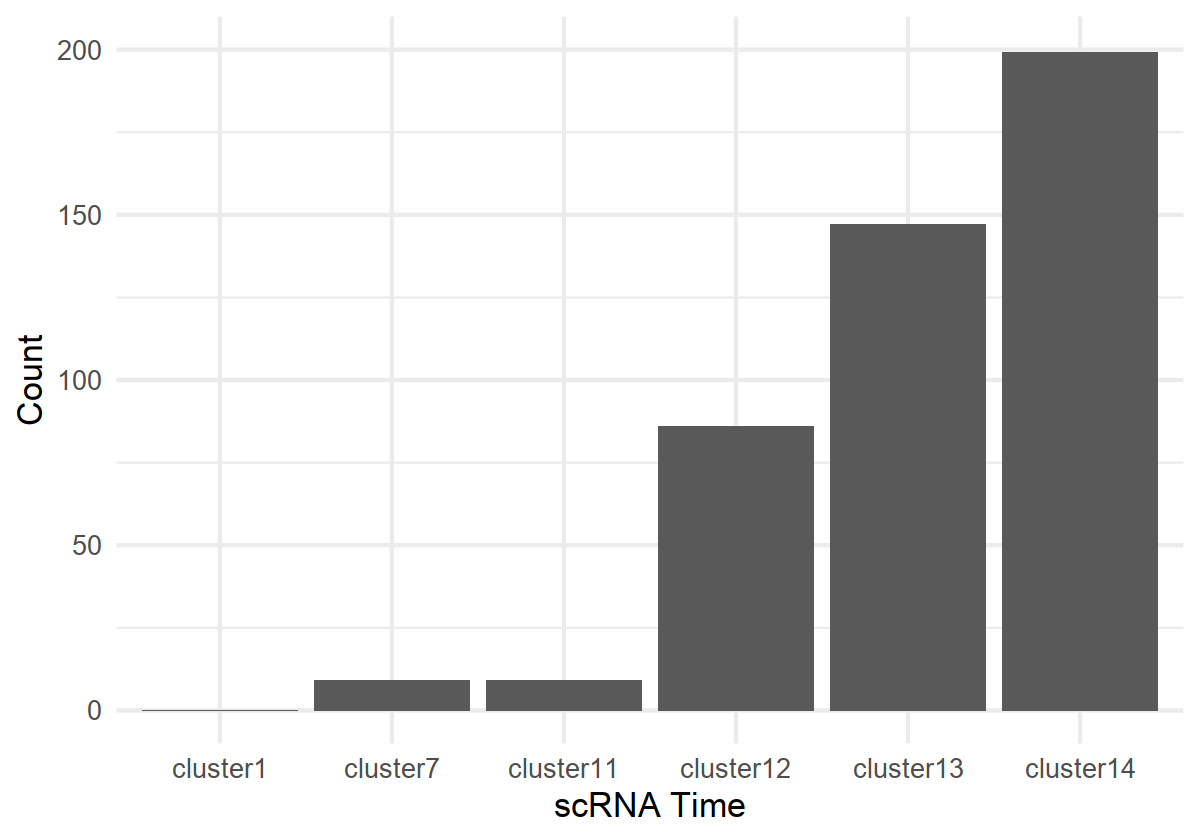

In [698]:
options(repr.plot.width = 10, repr.plot.height = 7)

CLUSTERS = c(1,7,11,12,13,14)
select_clusters = paste("cluster", CLUSTERS, sep='')

to_plot = colSums(scrna_bulk_tp10k[off_on_genes,select_clusters]>0.005)
to_plot = data.frame(x=names(to_plot),
                    y=to_plot)
to_plot$x = factor(to_plot$x, levels=to_plot$x)

ggplot(to_plot) + 
geom_bar(aes(x=x,y=y), stat="identity") +
theme_minimal(base_size = 20) +
ylim(c(0,200)) +
xlab("scRNA Time") +
ylab("Count")

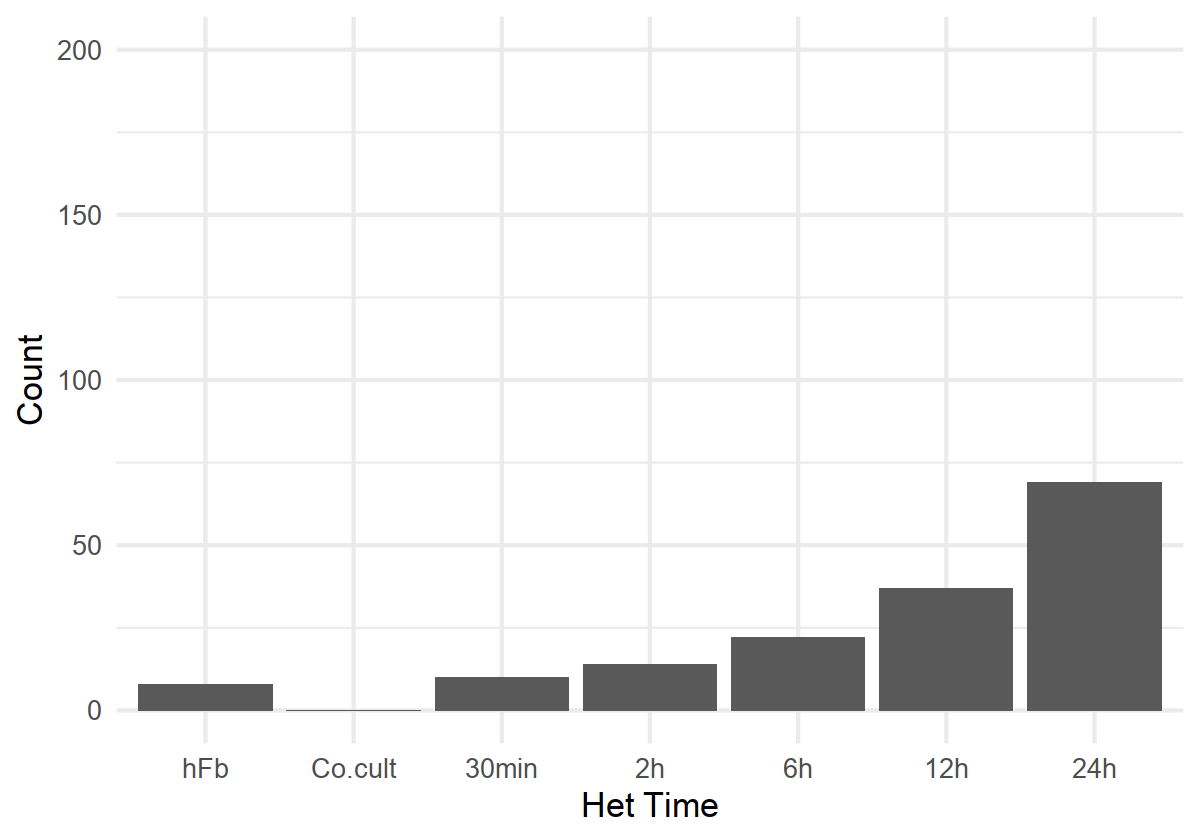

In [696]:
options(repr.plot.width = 10, repr.plot.height = 7)

to_plot = colSums(het_tp10k[off_on_genes, ]>0.005)
to_plot = data.frame(x=names(to_plot),
                    y=to_plot)
to_plot$x = factor(to_plot$x, levels=to_plot$x)

ggplot(to_plot) + 
geom_bar(aes(x=x,y=y), stat="identity") +
theme_minimal(base_size = 20) +
ylim(c(0,200)) +
xlab("Het Time") +
ylab("Count")

In [675]:
off_on_genes

[1] "AL390719.2"  "AL031280.1"  "LIN28A"      "POU3F1"      "KLF17"      
  [6] "ZYG11A"      "DMRTB1"      "FAM151A"     "TACSTD2"     "FOXD3-AS1"  
 [11] "FOXD3"       "BRDT"        "PIFO"        "LINC01356"   "LINC02805"  
 [16] "HORMAD1"     "C1orf61"     "CD48"        "MAEL"        "CR1L"       
 [21] "MIR205HG"    "LEFTY1"      "AL117348.1"  "ACTA1"       "GREB1"      
 [26] "AC106875.1"  "MYCN"        "KRTCAP3"     "TFCP2L1"     "RPRM"       
 [31] "CRYGD"       "LINC00607"   "ALPP"        "ALPG"        "EFHD1"      
 [36] "PTH1R"       "FRG2C"       "DPPA2"       "AC117382.2"  "AC128685.1" 
 [41] "GPR160"      "BEND4"       "CNGA1"       "GSX2"        "PDCL2"      
 [46] "SPINK2"      "LINC00989"   "ADH6"        "PANCR"       "SFRP2"      
 [51] "LRAT"        "TRIM60"      "SLCO4C1"     "CDX1"        "AC091820.2" 
 [56] "AC091820.1"  "GABRP"       "NKX2-5"      "LINC01108"   "GRM4"       
 [61] "DPPA5"       "KHDC3L"      "AL591030.1"  "FAM184A"     "FABP7"      
 [66] "TRDN"        "AL365259.1"  "HEY2"        "AL117378.1"  "PNLDC1"     
 [71] "UNC93A"      "DACT2"       "ICA1"        "SP8"         "CPVL"       
 [76] "C7orf57"     "ZNF727"      "CLDN3"       "NCF1"        "NPTX2"      
 [81] "LINC02577"   "AC003975.1"  "CNTNAP2"     "AC022784.2"  "ADAM18"     
 [86] "CA8"         "PRDM14"      "AC009446.1"  "LRATD2"      "LINC00824"  
 [91] "CCDC26"      "LRRC6"       "RLN2"        "TMEM215"     "FAM189A2"   
 [96] "PCSK5"       "LINC01508"   "AL590705.1"  "NR6A1"       "PRKCQ"      
[101] "ST8SIA6"     "GAD2"        "FXYD4"       "NODAL"       "SFTPD"      
[106] "TMEM254-AS1" "SORBS1"      "FGFR2"       "ART5"        "AC087521.2" 
[111] "LARGE2"      "C11orf72"    "FGF4"        "TRIM64B"     "LINC02700"  
[116] "TMPRSS4"     "CDON"        "AC084375.1"  "SCNN1A"      "DPPA3"      
[121] "FAM90A1"     "CLEC4D"      "AICDA"       "AC092490.1"  "KLRB1"      
[126] "CLEC7A"      "LINC02617"   "PLBD1"       "GUCY2C"      "IL23A"      
[131] "LINC01405"   "TESC"        "CCDC60"      "ATP12A"      "LINC00545"  
[136] "LCP1"        "LINC00458"   "ZIC2"        "VRTN"        "TCL1B"      
[141] "TUNAR"       "CGNL1"       "FOXB1"       "IGDCC3"      "CRABP1"     
[146] "AC091078.1"  "CLDN6"       "ZSCAN10"     "AC007218.1"  "PRKCB"      
[151] "AC008938.1"  "PRSS8"       "PYDC1"       "ITGAM"       "CDH8"       
[156] "NRN1L"       "DPEP3"       "CDH3"        "CDH1"        "LDHD"       
[161] "CHST5"       "AC005696.4"  "ASPA"        "PPP1R1B"     "GRB7"       
[166] "CSH1"        "L3MBTL4"     "CHST9"       "AC006305.1"  "LINC-ROR"   
[171] "ZNF556"      "TJP3"        "SHD"         "TMIGD2"      "NRTN"       
[176] "CRB3"        "EPHX3"       "PBX4"        "AC010615.2"  "AC123912.4" 
[181] "ZNF208"      "ZNF257"      "ZNF676"      "ZNF729"      "ZNF98"      
[186] "ZNF99"       "ZNF723"      "SYNE4"       "ZNF850"      "MAP4K1"     
[191] "CNTD2"       "LINC01480"   "AC008753.2"  "CACNG6"      "NLRP7"      
[196] "NLRP2"       "SLC52A3"     "AVP"         "WFDC2"       "TNNC2"      
[201] "MMP9"        "CTCFL"       "CHODL"       "AP000688.2"  "DSCR8"      
[206] "ERVH48-1"    "TBX1"        "RFPL2"       "FAM83F"      "PHF21B"     
[211] "VCX3A"       "VCX"         "VCX2"        "FAM9C"       "MAGEB2"     
[216] "FAAH2"       "SLC7A3"      "ITM2A"       "FAM133A"     "AL157778.1" 
[221] "TCEAL2"      "PLP1"        "RHOXF1-AS1"  "RHOXF1"      "TENM1"      
[226] "GPC3"        "ZIC3"        "FGF13"       "TKTL1"

In [616]:
cur_genes = off_on_genes[(het_tp10k[off_on_genes, "24h"]>.01)&(scrna_bulk_tp10k[off_on_genes, "cluster14"] >.01)]
cur_genes

[1] "FOXD3-AS1" "LEFTY1"    "KRTCAP3"   "ALPG"      "FRG2C"     "GPR160"   
 [7] "SFRP2"     "NODAL"     "ART5"      "FAM90A1"   "IL23A"     "ZIC2"     
[13] "CLDN6"     "ITGAM"     "CDH8"      "NRN1L"     "CDH3"      "PPP1R1B"  
[19] "GRB7"      "CNTD2"     "WFDC2"     "MMP9"      "TKTL1"

In [640]:
length(cur_genes)

[1] 23

In [613]:
write.table(cur_genes, "./tmp.txt", quote=F, row.names=F, col.names=F)

In [517]:
off_on_genes[(het_with_rep_tp10k[off_on_genes, "24h_rep1"]>.005)&
            (het_with_rep_tp10k[off_on_genes, "24h_rep2"]>.005)&
            (het_with_rep_tp10k[off_on_genes, "24h_rep3"]>.005)]

[1] "POU3F1"     "ZYG11A"     "FOXD3-AS1"  "FOXD3"      "LEFTY1"    
 [6] "GREB1"      "KCNS3"      "KRTCAP3"    "GALNT3"     "EFHD1"     
[11] "FRG2C"      "GPR160"     "CNGA1"      "GSX2"       "SFRP2"     
[16] "DND1"       "NKX2-5"     "GCNT2"      "ICA1"       "AC005062.1"
[21] "CLDN3"      "LRATD2"     "RLN2"       "FAM189A2"   "PCSK5"     
[26] "NXNL2"      "NODAL"      "ANKRD1"     "SORBS1"     "LARGE2"    
[31] "AP003096.1" "CDON"       "AC092490.1" "PMEL"       "SYCP3"     
[36] "TESC"       "ZIC2"       "DEGS2"      "IGDCC3"     "PRSS8"     
[41] "ITGAM"      "CDH8"       "CDH3"       "HAS3"       "RAB11FIP4" 
[46] "GRB7"       "TJP3"       "EPHX3"      "PBX4"       "SYNE4"     
[51] "ZNF850"     "MAP4K1"     "CNTD2"      "FAM71E1"    "MMP9"      
[56] "FAM83F"     "ARHGAP4"    "TKTL1"

In [829]:
THRESH = 0.1

on_off_genes = c(gene_sets[[3]], gene_sets[[9]])
on_off_genes = on_off_genes[on_off_genes %in% common_genes]
on_off_genes = on_off_genes[on_off_genes %in% VariableFeatures(rna)]

# more than THRESH*100 TPM in fibroblasts
on_off_genes = on_off_genes[scrna_bulk_tp10k[on_off_genes, "cluster1"] > THRESH]

# more than THRESH*100 TPM in het fibroblasts?
on_off_genes = on_off_genes[het_tp10k[on_off_genes, "Co.cult"] > THRESH]

# # less than THRESH*100 TPM in C14 (D14 pre-iPSC)
# on_off_genes = on_off_genes[scrna_bulk_tp10k[on_off_genes, "cluster14"] > THRESH]

length(on_off_genes)

colSums(het_tp10k[on_off_genes, ]>0)
colSums(het_tp10k[on_off_genes, ]>0.001)
colSums(het_tp10k[on_off_genes, ]>0.005)
colSums(het_tp10k[on_off_genes, ]>0.01)
colSums(het_tp10k[on_off_genes, ]>0.1)

colSums(het_with_rep_tp10k[on_off_genes,] > THRESH)
colSums(scrna_bulk_tp10k[on_off_genes,] > THRESH)

[1] 210

hFb Co.cult   30min      2h      6h     12h     24h 
    210     210     210     210     210     210     210

hFb Co.cult   30min      2h      6h     12h     24h 
    210     210     210     210     210     210     210

hFb Co.cult   30min      2h      6h     12h     24h 
    210     210     210     210     210     210     210

hFb Co.cult   30min      2h      6h     12h     24h 
    210     210     210     210     210     210     209

hFb Co.cult   30min      2h      6h     12h     24h 
    204     210     207     204     196     194     193

hFb_rep1     hFb_rep2     hFb_rep3 Co.cult_rep1 Co.cult_rep2 Co.cult_rep3 
         202          200          200          204          206          203 
  30min_rep1   30min_rep2   30min_rep3      2h_rep1      2h_rep2      2h_rep3 
         207          209          202          202          204          199 
     6h_rep1      6h_rep2      6h_rep3     12h_rep1     12h_rep2     12h_rep3 
         195          191          195          186          187          194 
    24h_rep1     24h_rep2     24h_rep3 
         191          191          184

cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  cluster7  cluster8 
      210       190       198       195       190       190       176       144 
 cluster9 cluster10 cluster11 cluster12 cluster13 cluster14 
      171       160       148       133       101        78

In [854]:
colSums(het_tp10k[on_off_genes, ] > het_tp10k[on_off_genes, "Co.cult"]/2)

hFb Co.cult   30min      2h      6h     12h     24h 
    193     210     209     199     174     145     139

In [851]:
colSums(scrna_bulk_tp10k[on_off_genes,] > scrna_bulk_tp10k[on_off_genes, "cluster1"]/2)

cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  cluster7  cluster8 
      210       100       140       131       133        88        70        48 
 cluster9 cluster10 cluster11 cluster12 cluster13 cluster14 
       58        44        41        30        10         8

In [350]:
on_off_genes

[1] "FMO2"       "CHI3L1"     "EPAS1"      "NR4A2"      "FRZB"      
 [6] "OXTR"       "COL8A1"     "FILIP1L"    "PTX3"       "RARRES1"   
[11] "FGF5"       "ADH1B"      "IL7R"       "PTGER4"     "TSLP"      
[16] "EDN1"       "CFB"        "PSMB9"      "TCF21"      "HGF"       
[21] "SAMD9"      "WNT2"       "CPA4"       "TRBC2"      "TMEM176B"  
[26] "TMEM176A"   "TRIM55"     "CRH"        "TRPA1"      "BAALC"     
[31] "CCN3"       "FBXO32"     "PAPPA"      "SRGN"       "LOXL4"     
[36] "HBD"        "MICAL2"     "PGA5"       "BIRC3"      "MMP1"      
[41] "MMP3"       "NNMT"       "KRT7"       "GLIPR1"     "GALNT9"    
[46] "FBLN5"      "BDKRB2"     "BDKRB1"     "GREM1"      "ITPKA"     
[51] "CTSH"       "CEMIP"      "CALB2"      "CDH13"      "XAF1"      
[56] "KRTAP1-5"   "KRTAP2-3"   "TBX2"       "SLC14A1"    "SERPINB7"  
[61] "SERPINB2"   "PSG5"       "PSG4"       "GDF5"       "CCN5"      
[66] "AL353653.1" "APCDD1L"    "TNFRSF6B"   "WNT7B"      "CDKN2C"    
[71] "LINC01133"  "CFH"        "TNFAIP6"    "BCHE"       "MSX1"      
[76] "ATP10D"     "CXCL3"      "MEF2C"      "JAKMIP2"    "FGL2"      
[81] "PRSS3"      "DKK1"       "FGF7"       "OMG"        "APCDD1L-DT"
[86] "NR0B1"

## Compute Similarity

In [397]:
genes_of_interest = c(gene_sets[[2]], gene_sets[[7]])
# genes_of_interest = c(gene_sets[[4]])
# genes_of_interest = common_genes

genes_of_interest = genes_of_interest[genes_of_interest %in% common_genes]

# only in top 2k variable genes?
genes_of_interest = genes_of_interest[genes_of_interest %in% VariableFeatures(rna)]

# exclude exogenous genes
genes_of_interest = genes_of_interest[!genes_of_interest %in% c("POU5F1", "SOX2", "KLF4", "MYC")]

length(genes_of_interest)

[1] 414

In [699]:
scrna_subset = as.matrix(scrna_tp10k_log[genes_of_interest, ])
het_subset = het_tp10k_log[genes_of_interest, ]
                         
# scrna_subset = t(scale(t(as.matrix(scrna_tp10k_log[genes_of_interest, ]))))
# het_subset = t(scale(t(het_tp10k_log[genes_of_interest, ])))

In [700]:
exclude = rownames(het_subset)[rowSums(is.na(het_subset))>0]

scrna_subset = scrna_subset[!rownames(scrna_subset) %in% exclude, ]
het_subset = het_subset[!rownames(het_subset) %in% exclude, ]

In [701]:
dim(scrna_subset)
dim(het_subset)

[1]   414 59369

[1] 414   7

In [702]:
all(colnames(scrna_subset) == colnames(rna))

[1] TRUE

In [703]:
sum(is.na(het_subset))

[1] 0

In [704]:
sim_scores = matrix(0, ncol(het_subset), ncol(scrna_subset))
colnames(sim_scores) = colnames(scrna_subset)
rownames(sim_scores) = colnames(het_subset)


for (i in seq(ncol((het_subset)))) {
    # cosine similarity
    sim_scores[i, ] = (colSums(scrna_subset*het_subset[,i])/(sqrt(sum(het_subset[,i]^2)*colSums(scrna_subset^2))))
    
    # correlation
#     sim_scores[i, ] = cor(scrna_subset, het_subset[,i])
}

In [705]:
cor(t(sim_scores), method='spearman')

,hFb,Co.cult,30min,2h,6h,12h,24h
hFb,1.0000000,0.9941273,0.9948411,0.9936033,0.9907111,0.9878172,0.9884544
Co.cult,0.9941273,1.0000000,0.9989749,0.9962870,0.9908474,0.9875438,0.9879056
30min,0.9948411,0.9989749,1.0000000,0.9976788,0.9916180,0.9880788,0.9884952
2h,0.9936033,0.9962870,0.9976788,1.0000000,0.9957893,0.9917293,0.9905002
6h,0.9907111,0.9908474,0.9916180,0.9957893,1.0000000,0.9973939,0.9920079
12h,0.9878172,0.9875438,0.9880788,0.9917293,0.9973939,1.0000000,0.9960743
24h,0.9884544,0.9879056,0.9884952,0.9905002,0.9920079,0.9960743,1.0000000


In [706]:
plots = list()
j = 1
for (i in rownames(sim_scores)) {
    df = data.frame(umap1=rna@reductions$umap@cell.embeddings[,"UMAP_1"], 
                    umap2=rna@reductions$umap@cell.embeddings[,"UMAP_2"], 
                    sim=sim_scores[i, ])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]

    plots[[j]] <- ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=.5, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=sim)) +
    ggtitle(i) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=c(quantile(sim_scores[i, ], 0.05),
                                   quantile(sim_scores[i, ], 0.99)), oob=squish, option = "A") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
    #      legend.position = "none",
         axis.ticks = element_blank(),
         axis.text =element_blank(),
         axis.line=element_blank(),
         panel.border = element_rect(colour = "black", fill=NA, size=0.5))
    
    j = j+1
}

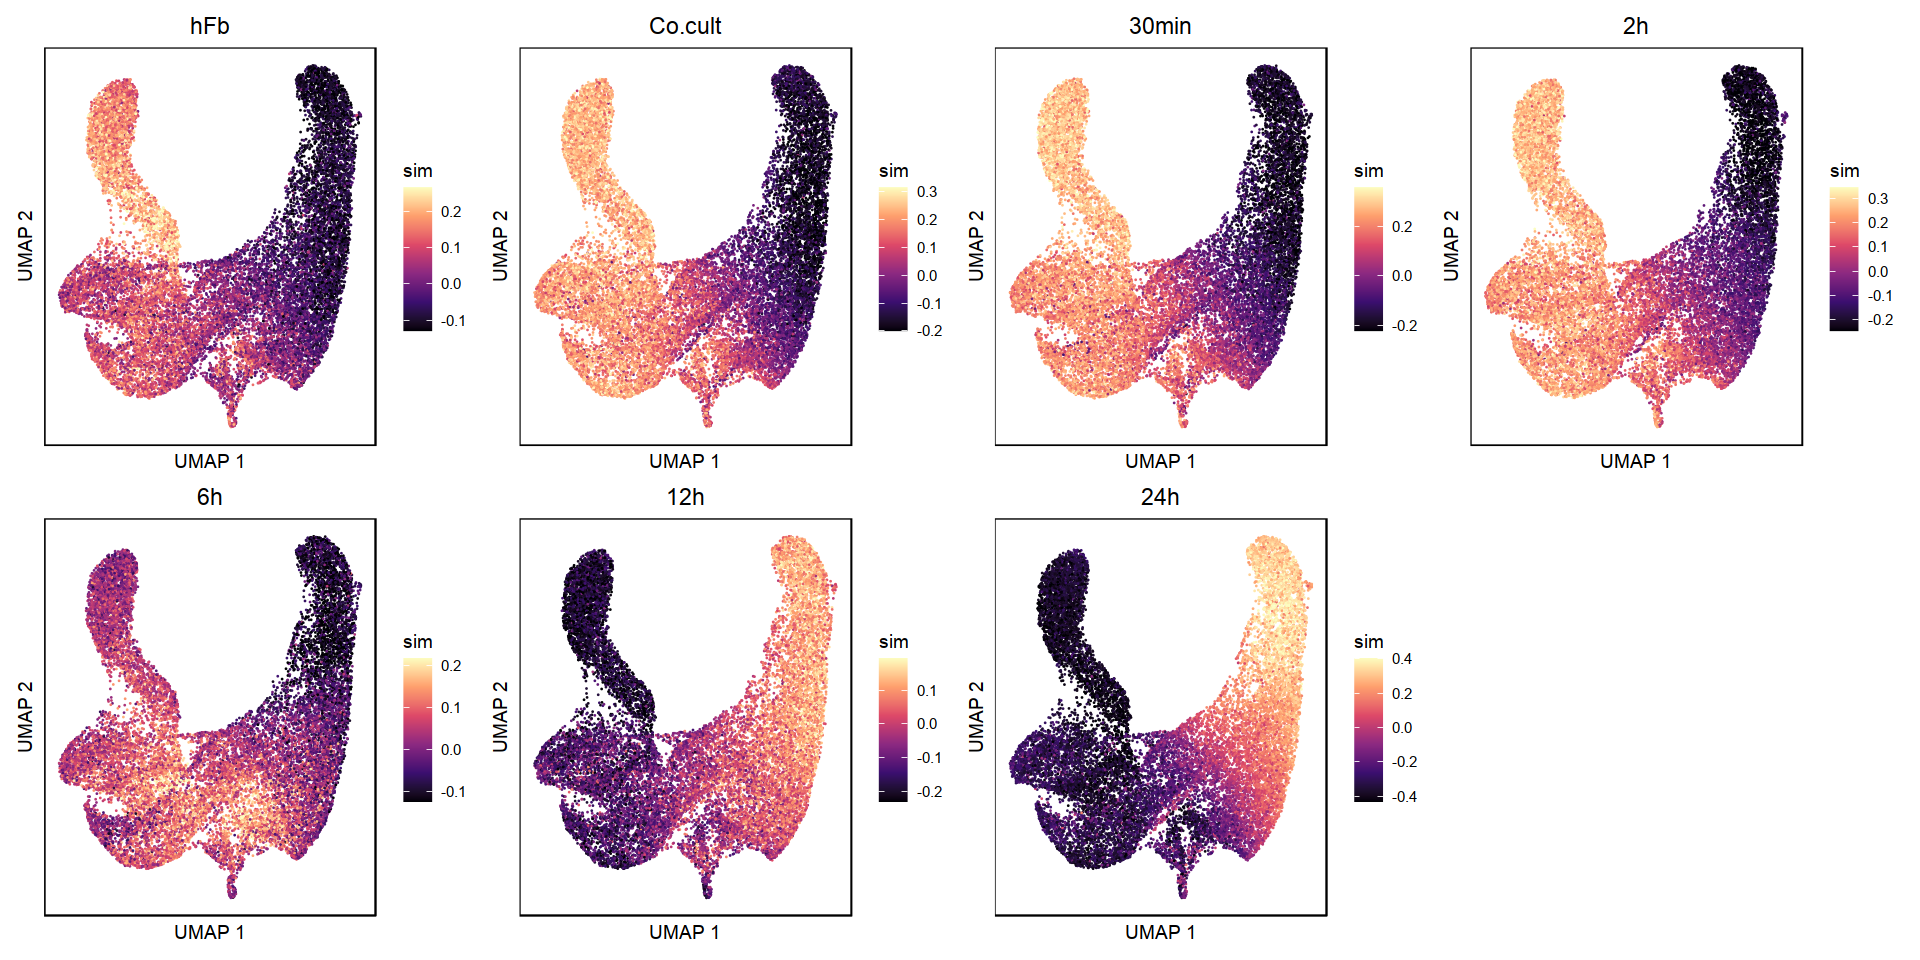

In [419]:
options(repr.plot.width = 16, repr.plot.height = 8)

wrap_plots(plots, nrow=2)

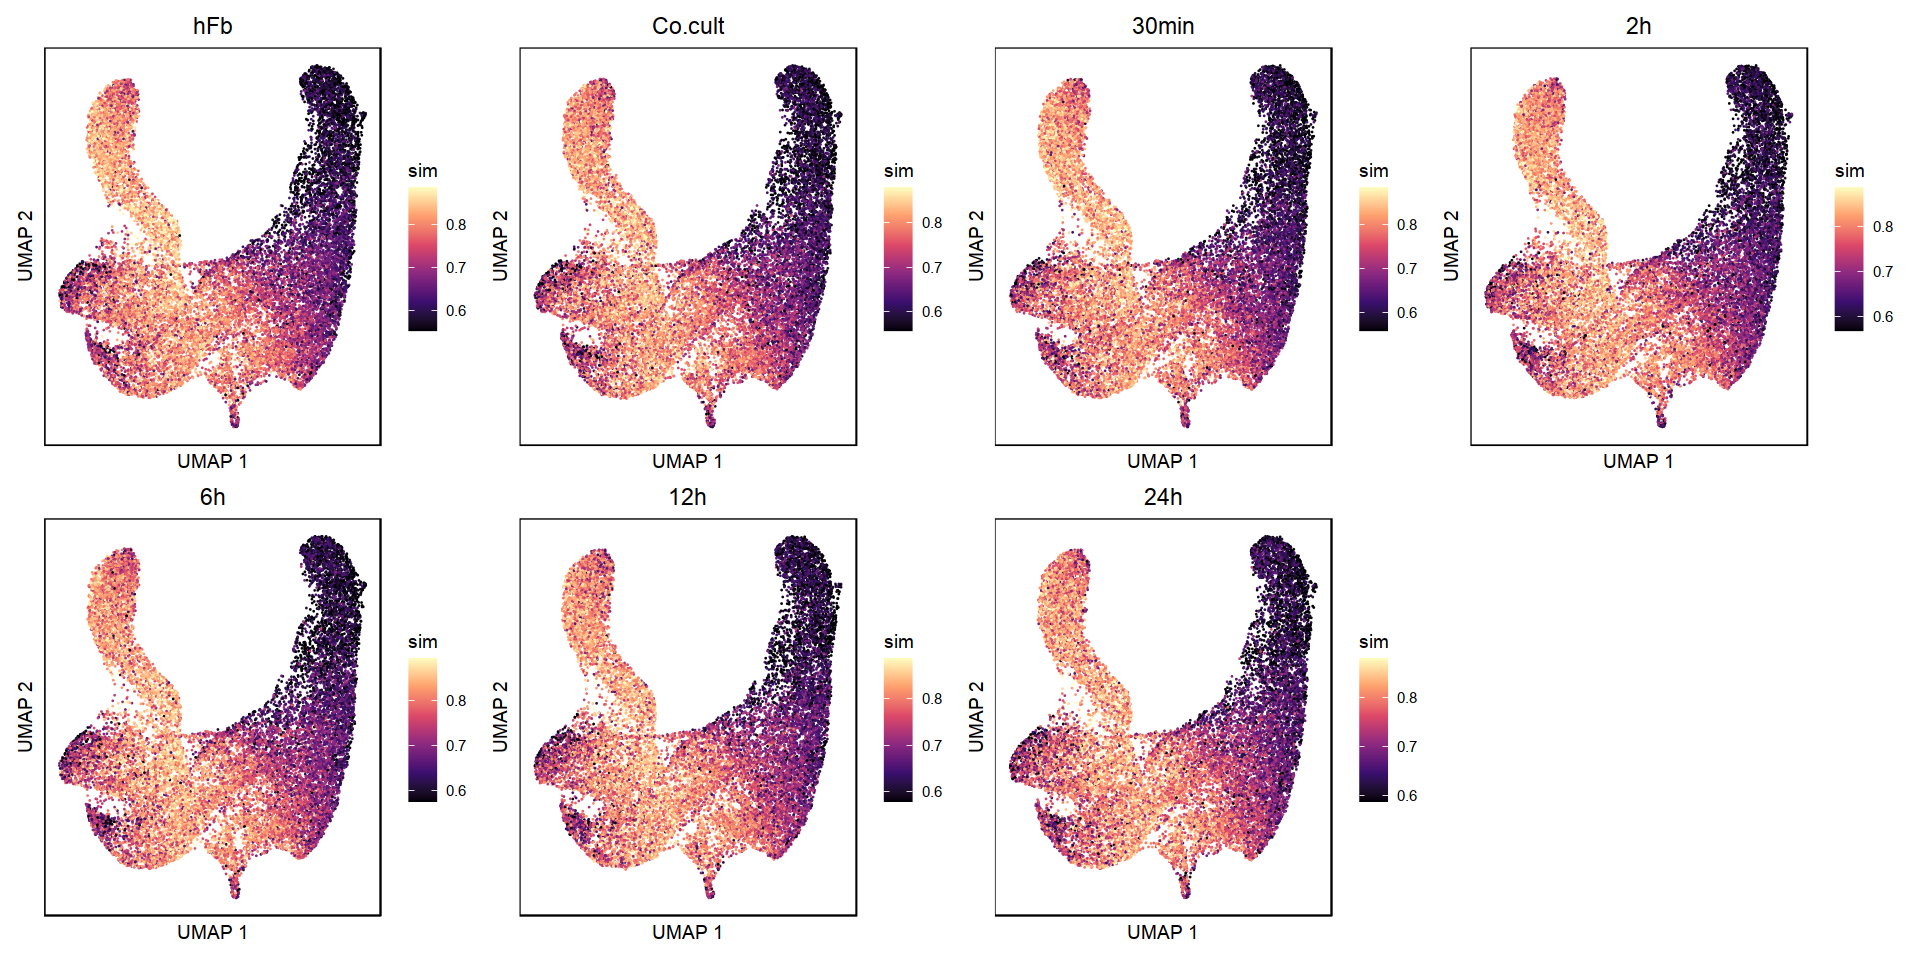

In [707]:
options(repr.plot.width = 16, repr.plot.height = 8)

# raw corrs

wrap_plots(plots, nrow=2)

---

In [ ]:
sessionInfo()